In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from waveletFunctions import wavelet, wave_signif
import matplotlib.patheffects as PathEffects
plt.style.use('default')

In [7]:
dftk = pd.read_csv('./residual_tide_japan.csv',index_col=0)
dftk = dftk[100:-100]
print(f'Shape:{dftk.shape}')
dftk.head()

Shape:(376, 15)


,Kushiro_Residual,Miyako_Residual,Ofunato_Residual,Ayukawa_Residual,Onahama_Residual,Chichijima_Residual,Hachijojima_Residual,Irozaki_Residual,Omaezaki_Residual,Kushimoto_Residual,Muroto_Residual,Tosashimizu_Residual,Aburatsu_Residual,Makurazaki_Residual,Amami_Residual
Time_min_Tide,,,,,,,,,,,,,,,
500,-1.666851,-3.512876,1.077767,-3.493265,1.713165,3.115827,-1.687996,-4.491977,-4.246978,-2.306686,-0.998228,-2.524061,8.510877,3.205834,1.042752
505,-0.945957,-1.787572,-3.225262,-3.715644,0.596594,0.620414,-1.210113,-2.787531,-3.473784,-2.358939,0.129486,0.626004,-0.326475,-2.326591,-4.688397
510,0.755942,-2.089555,-4.564355,3.031056,-1.548237,-3.889972,0.242453,-0.116056,0.274480,0.571233,2.238637,-0.245228,-5.171272,4.180801,5.586439
515,0.439092,-3.417979,1.063978,-1.252415,0.280427,-0.415921,-3.331615,-0.479292,-2.004475,-0.518342,-0.674473,-3.140919,-4.026194,3.727370,-4.135745
520,-2.896152,0.228228,-0.336262,-0.565125,3.084201,2.042161,1.066603,-2.878704,1.687166,-0.629731,-0.613611,-2.064062,0.106160,-4.687993,2.142036


In [280]:
# colores = ['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8','#911eb4','#f032e6']
def plot_stations(data,stations):
    t_total = data.shape[0]*5/60. #horas
    alto  = 4
    ancho = 10
    dt = 5*60  # time step (sec)
    fig1=plt.figure(1,figsize=(ancho, alto))
    fig1.subplots_adjust(hspace=0.025, wspace=0.025)
    for i in range(len(stations)):
        eta  = data #data[:,0] # free surface in (cm)
        dt = 5*60  # time step (sec)
        time = np.arange(0,(dt*len(eta)),dt) #time in seconds
        time = (time/(60*60)) - 15/60 #time in hours
        eta = eta[::4]
        time = time[::4]
        eta = eta[:-1]
        time = time[:-1]

        # WAVELET PARAMETERS
        n    = len(eta)
        dt   = dt/60.0 # en minutos
        pad  = 0  # pad the time series with zeroes (recommended)
        dj   = 0.125  # this will do 8 sub-octaves per octave
        s0   = 2 * dt  # this says start at a scale of 2 sec (?)
        j1   = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
        lag1 = 0.72  # lag-1 autocorrelation for red noise background
        mother = 'MORLET'

        # Wavelet transform:
        wave, period, scale, coi = wavelet(eta/100.0, dt, pad, dj, s0, j1, mother)
        power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
        Frec = 1.0/period
        global_ws = (np.sum(power, axis=1) / n )  # time-average over all times
        average_time = (np.sum(power, axis=0)) #/ n
        integrate_time = np.trapz(power,x=period,axis=0)


        # Wavelet distribution time-Frequency
        plt.figure(1) # set current figure to fig1
        ax = plt.subplot2grid((len(stations), 6), (i, 0), colspan=5)
        levels = [2.**x for x in np.arange(-14,0,0.5)]
        # levels = [0.0019/2048, 0.0019/1024, 0.0019/512, 0.0019/256, 0.0019/128, 0.0019/64, 0.0019/32, 0.0019/16,  0.0019/8, 0.0019/4, 0.0019/2, 0.0019, 0.0039, 0.0078, 0.0157, 0.0313, 0.0625,0.125,0.25,0.5,1,2,4,8,16,32]#,64,128]
        cs = ax.contourf(time,np.log2(period),np.log2(power),np.log2(levels),cmap=plt.cm.jet,extend='both')
        txtl = ax.text(t_total-1,np.log2(500),stations[i],fontsize=16, fontweight='bold',horizontalalignment='right',verticalalignment='top')
        txtl.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
        Yticks = 2**np.log2([8, 16, 32, 64, 128, 256, 512])
        ax.set_yticks(np.log2(Yticks))
        ax.set_yticklabels([8, 16, 32, 64, 128, 256, 512])
        ax.set_ylim(np.log2(period.min()),np.log2(512))
        ax.set_xlim(0,time.max())

        # Wavelet Spectrum Plot
        ax2 = plt.subplot2grid((len(stations), 6), (i, 5))
        ax2.semilogx(global_ws,np.log2(period))
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        ax2.set_yticks(np.log2(Yticks))
        ax2.set_yticklabels([8, 16, 32, 64, 128, 256, 512])
        ax2.set_xticks([10**-4,10**-3,10**-2,10**-1])
        ax2.set_ylim(np.log2(period.min()),np.log2(512))
        ax2.set_xlim(10**-5,10**0)
        ax2.grid(color='lightgray', linestyle='--', linewidth=0.5)
        for tick in ax2.get_xticklabels():
                tick.set_rotation(55)

        if i == len(stations)-1:
            ax.set_xlabel('Relative time (hours)')
            ax.set_ylabel('Period (min)')
        
        cbar = fig1.colorbar(cs,ax=ax,location='left')
        cbar.ax.set_ylabel('dB')
        fig1.tight_layout()
        plt.savefig(f'./figs/{stations[0]}.png',dpi=600)
        plt.show()

In [281]:
stations = dftk.columns.to_list()

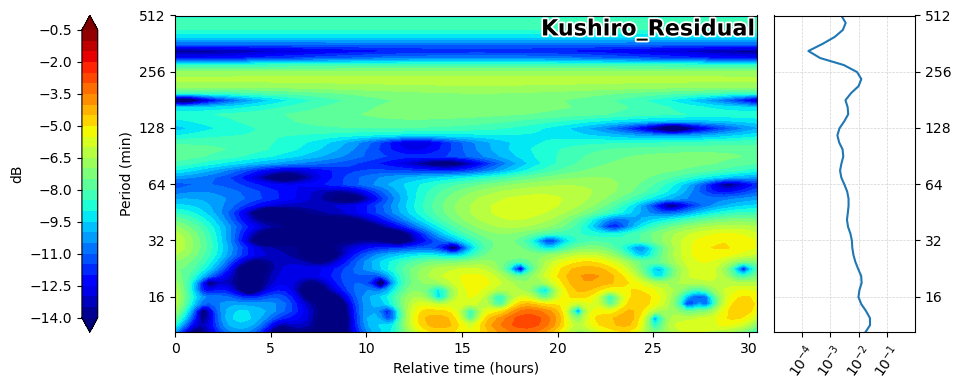

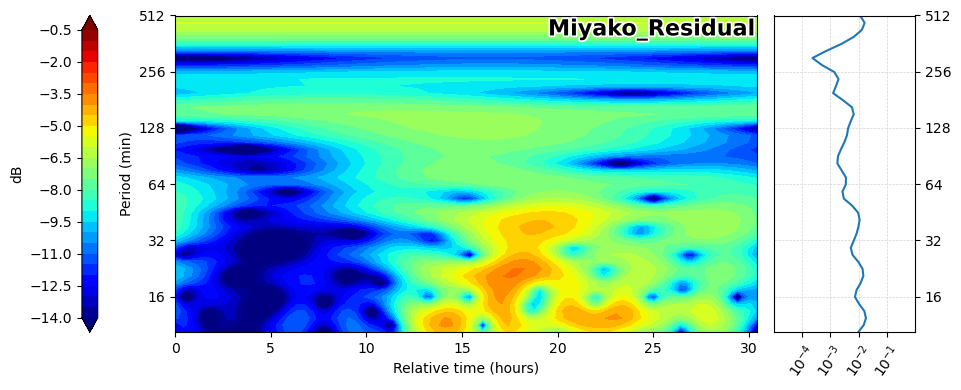

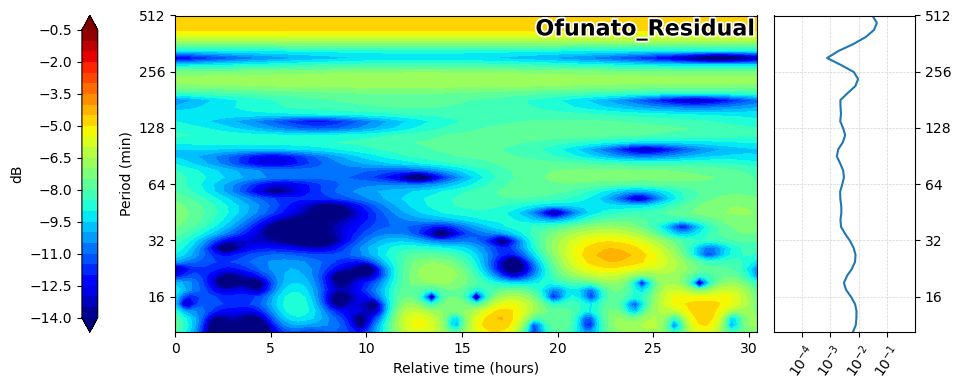

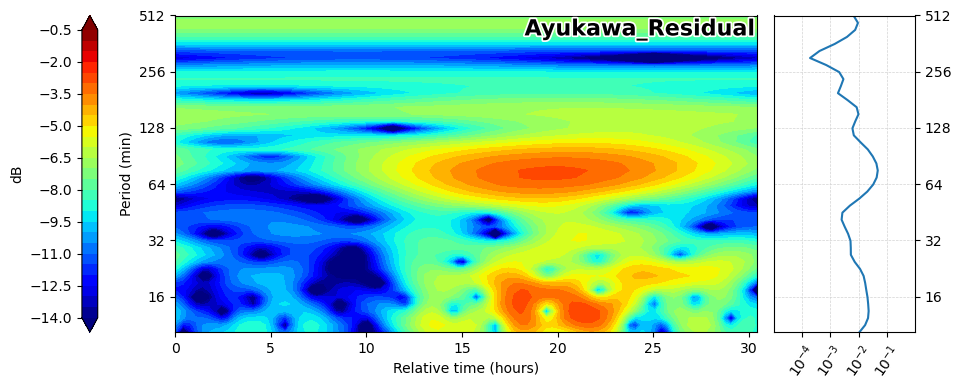

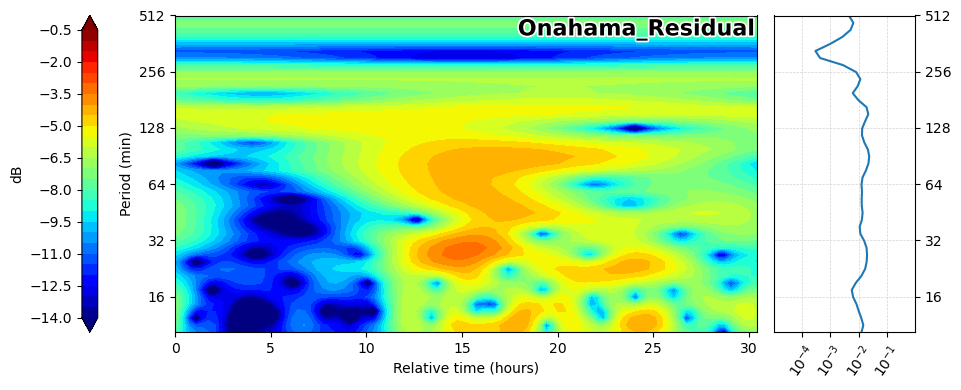

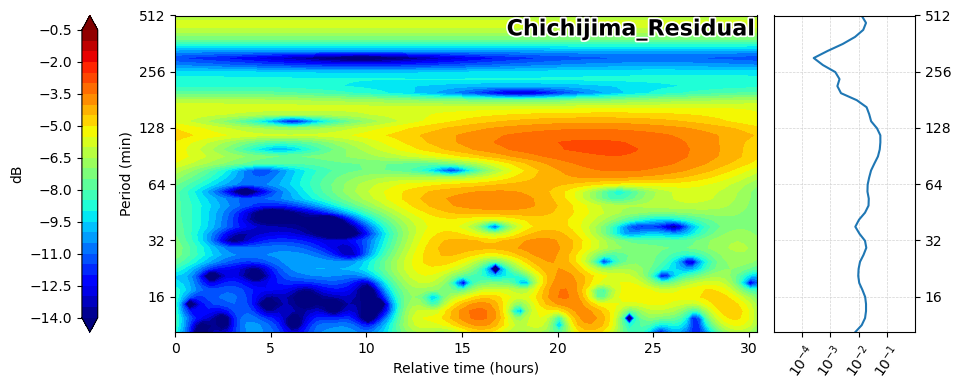

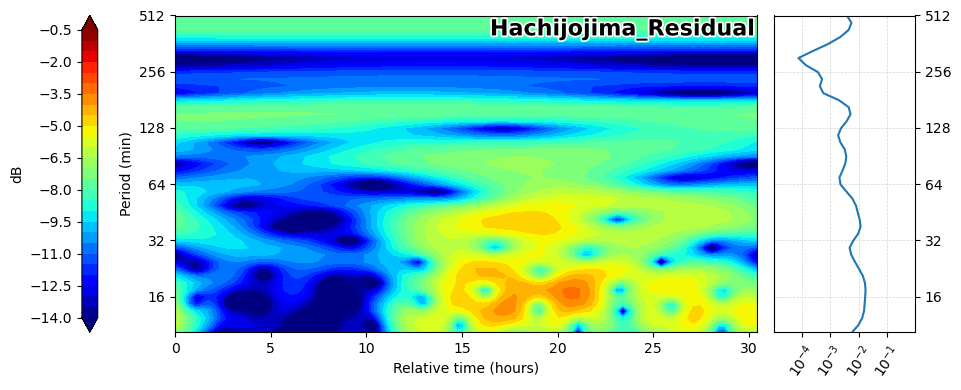

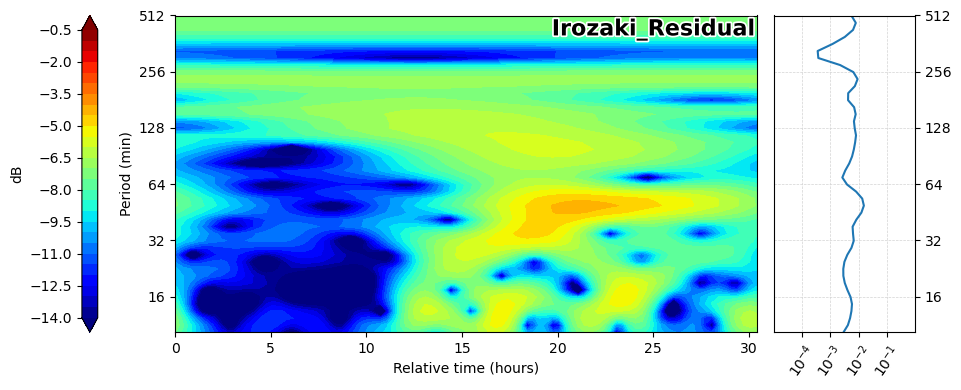

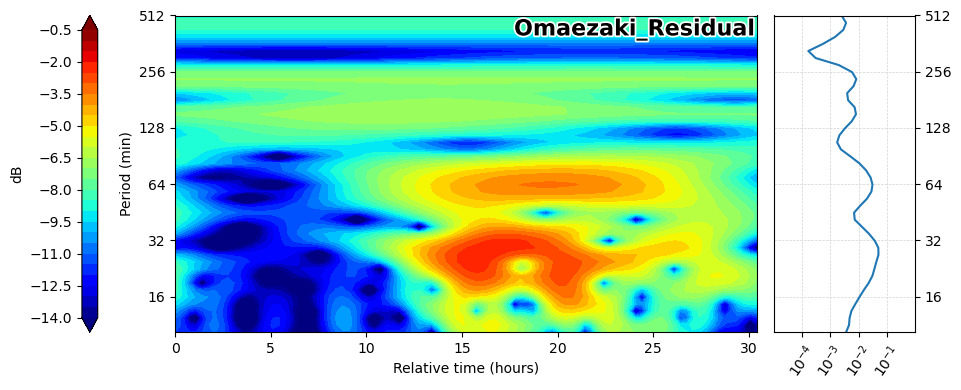

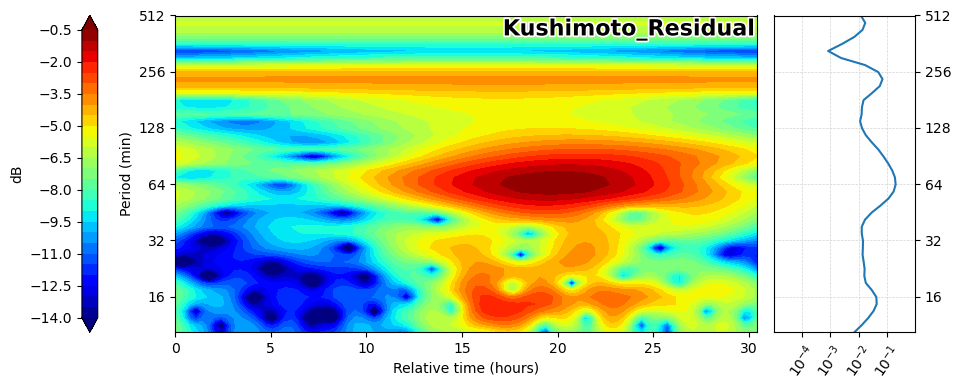

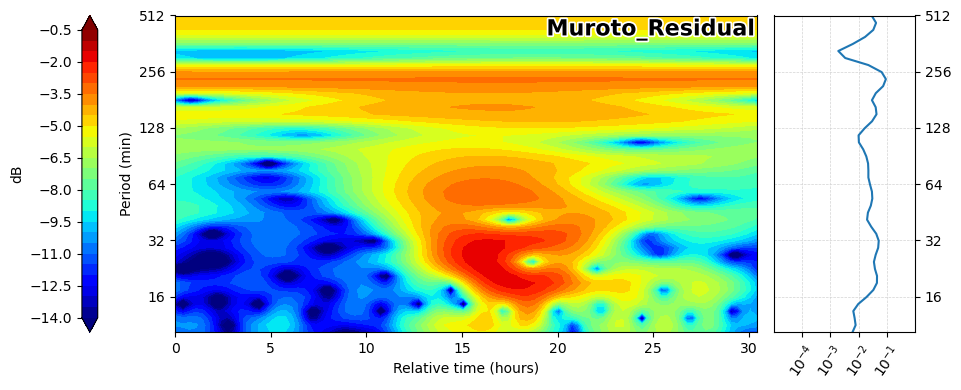

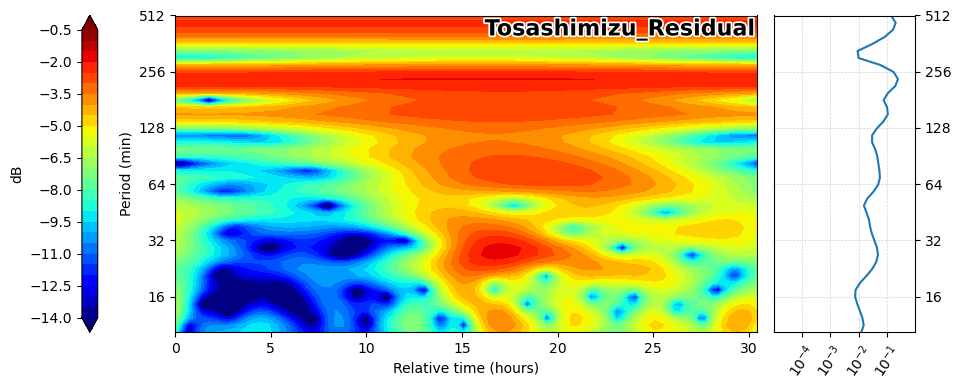

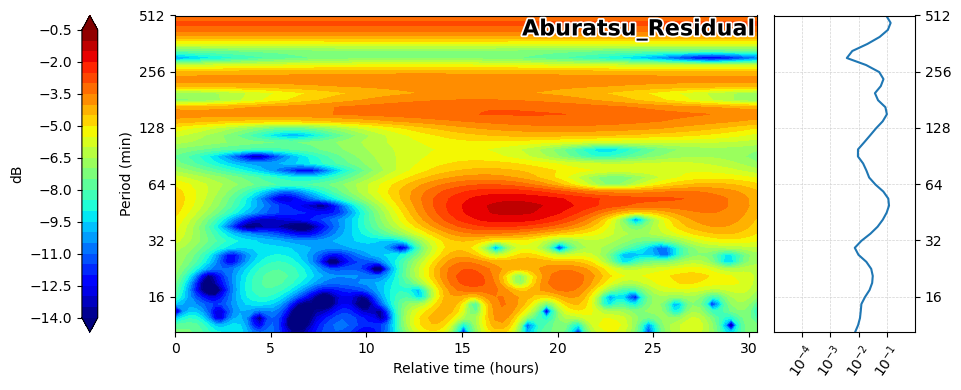

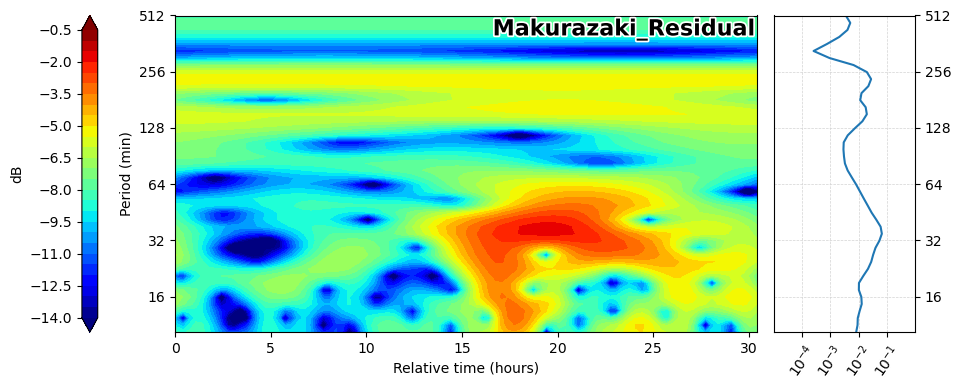

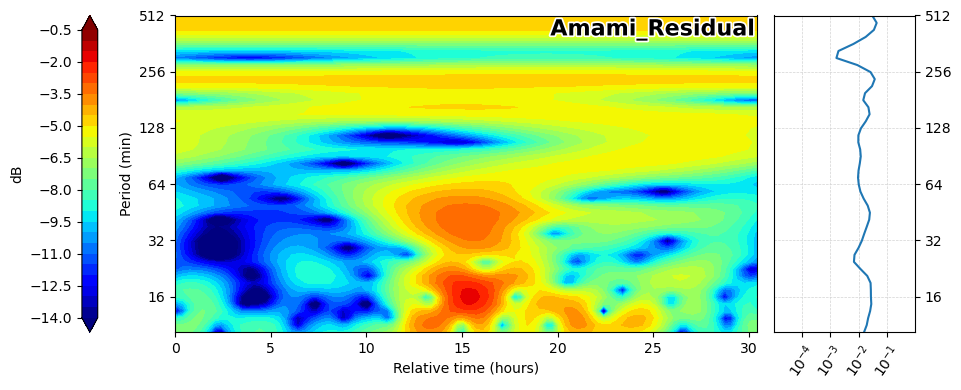

In [282]:
for row in dftk.iteritems():
    data = row[1].to_numpy()
    plot_stations(data,stations=[row[0]])

# Continous Wavelet Transform

In [ ]:
import pandas as pd
import matplotlib.style as mpls
mpls.use('default')

## Tide data

In [ ]:
dft = pd.read_csv('./data/tide_japan.csv',index_col=0)
dft = dft[100:-100] #not using first and last 100 records
print(f'Shape:{dft.shape}')
dft.head()

In [ ]:
dft.plot(subplots=True,layout=(5,3),sharex=True,sharey=True,figsize=(15,15),lw=1);

## Detided data

In [ ]:
dftk = pd.read_csv('./data/residual_tide_japan.csv',index_col=0)
dftk = dftk[100:-100]
print(f'Shape:{dftk.shape}')
dftk.head()

In [ ]:
dftk.plot(subplots=True,layout=(5,3),sharex=True,sharey=True,figsize=(15,15),lw=1);

## Plot waveform and CWT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mpls
from scipy import signal
mpls.use('default')

def freq2period(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = 10e2
    x[~near_zero] = 1 / x[~near_zero]
    return x

df_cwt = dftk
col = 14
sign = df_cwt.iloc[:,col].to_numpy()
xt = np.arange(0,df_cwt.shape[0],1)
## RIcker (Mexican hat)
# a,b = 2,180 #is this 10min to 900min=15h?
# widths = np.arange(a,b)
# cwtmatr = signal.cwt(sign,signal.ricker,widths)

## Morlet
fs = 1/5
w=6.
freq=np.linspace(1/180,1/2,len(sign))
p = [1/x for x in freq]
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(sign,signal.morlet2,widths,w=w)

fig,axs = plt.subplots(2,sharex=True,figsize=(8,8))
xt = np.arange(0,df_cwt.shape[0],1)
axs[0].plot(xt,sign,c='k',lw=0.5)
axs[0].set_ylabel('h,m')
axs[0].set_title(f'Tide: {df_cwt.columns[col]}')

im = axs[1].pcolormesh(xt,freq, np.abs(cwtm), cmap='jet', 
                       shading='gouraud')
                      # vmin=120,vmax=140)
                      #  vmin=-abs(cwtm).max(),vmax=abs(cwtm).max())
# im = axs[1].imshow(cwtmatr,cmap='jet',extent=[0,len(sign),a,b],aspect='auto',
                  #  vmin=-10,vmax=5)
                #    vmin=-abs(cwtmatr).max(),vmax=abs(cwtmatr).max())

axs[1].contour(xt,freq,np.abs(cwtm),colors='k',origin='upper',linewidths=0.5)
axs[1].set_title(f'Continous Wavelet Transform: {df_cwt.columns[col]}')
# # axs[1].set_xlim(500,2250)
axs[1].set_xlabel('Time(min)')
# # axs[1].set_xticks(xt)
# # axs[1].set_xticklabels(xl)
axs[1].set_ylabel('Frequency (cpm)')
# # axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# axs[1].set_ylim(a,b)


secax = axs[1].secondary_yaxis('right',functions=(freq2period,freq2period))
secax.set_yticks([2,5,15,30,180])
secax.set_yticklabels([2,5,15,30,180])
secax.set_ylabel('Period [min]')
fig.subplots_adjust(right=0.78)
cbar_ax = fig.add_axes([0.85,0.11,0.025,0.35])
fig.colorbar(im,cax=cbar_ax,label='Log2 (spectral energy)')

## Plot All wf and cwt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mpls
from scipy import signal
mpls.use('default')
plt.ioff()

def freq2period(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = 10e2
    x[~near_zero] = 1 / x[~near_zero]
    return x

def cwt_plot(col,df_cwt,save=False):
  col = col
  sign = df_cwt.iloc[:,col].to_numpy()
  xt = np.arange(0,df_cwt.shape[0],1)
  ## Morlet
  fs = 1/5
  w=6.
  freq=np.linspace(1/180,1/2,len(sign))
  widths = w*fs / (2*freq*np.pi)
  cwtm = signal.cwt(sign,signal.morlet2,widths,w=w)
  cwtm = np.abs(cwtm)
  # cwtm = cwtm.real
  # cwtm = np.log2(cwtm)

  fig,axs = plt.subplots(2,sharex=True,figsize=(8,8))
  xt = np.arange(0,df_cwt.shape[0],1)
  axs[0].plot(xt,sign,c='k',lw=0.5)
  axs[0].set_ylabel('h,m')
  axs[0].set_title(f'Tide: {df_cwt.columns[col]}')

  im = axs[1].pcolormesh(xt,freq,cwtm, cmap='jet', 
                        shading='gouraud',vmin=0,vmax=80)

  # axs[1].contour(xt,freq,cwtm,colors='k',origin='upper',linewidths=0.5)
  axs[1].set_title(f'Continous Wavelet Transform: {df_cwt.columns[col]}')
  axs[1].set_xlabel('Time(min)')
  axs[1].set_ylabel('Frequency (cpm)')
  
  secax = axs[1].secondary_yaxis('right',functions=(freq2period,freq2period))
  secax.set_yticks([2,5,15,30,180])
  secax.set_yticklabels([2,5,15,30,180])
  secax.set_ylabel('Period [min]')
  fig.subplots_adjust(right=0.78)
  cbar_ax = fig.add_axes([0.85,0.11,0.025,0.35])
  fig.colorbar(im,cax=cbar_ax,label='spectral energy')
  if save:
    plt.savefig(f'./cwt_figs/{col:03d}.png')

In [ ]:
plt.ioff()
for i in range(15):
    cwt_plot(i,dftk,False)

----

In [ ]:
import numpy as np
import matplotlib.style as mpls
mpls.use('default')

dft = dftk

def freq2period(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = 10e2
    x[~near_zero] = 1 / x[~near_zero]
    return x

def plot_spec(col=14, nfft=4, save=False, id=0):
    dt = 5
    sign = dft.iloc[:,col].to_numpy()
    xt = np.arange(0,dft.shape[0],1)
    # xl = np.arange(-250,dft.shape[0]*5,250)

    fig,axs = plt.subplots(2,sharex=True,figsize=(8,8))
    #plot waveform
    axs[0].plot(xt,sign,c='k',lw=0.5)
    axs[0].set_ylabel('h,m')
    axs[0].set_title(f'Tide: {dft.columns[col]}')
    
    #plot spectogram
    s,f,t,im = axs[1].specgram(sign,NFFT=nfft,Fs=5/dt,noverlap=nfft-2,cmap='jet',mode='psd')#,vmin=0,vmax=14)
    axs[1].set_title(f'Spectogram: {dft.columns[col]} / NFFT:{nfft}')
    # axs[1].set_xlim(500,2250)
    axs[1].set_xlabel('Time(min)')
    # axs[1].set_xticks(xt)
    # axs[1].set_xticklabels(xl)
    axs[1].set_ylabel('Frequency (cpm)')
    # axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # axs[1].set_ylim(10e-2,5e-1)

    #Second axis
    secax = axs[1].secondary_yaxis('right',functions=(freq2period,freq2period))
    secax.set_yticks([2,5,10])
    secax.set_yticklabels([2,5,10])
    secax.set_ylabel('Period [min]')
    
    #Colobar
    fig.subplots_adjust(right=0.75)
    cbar_ax = fig.add_axes([0.85,0.1,0.025,0.35])
    fig.colorbar(im,cax=cbar_ax)
    cbar_ax.set_title('dB');
    
    if save:
        plt.savefig(f'./figs_k/{id:04}.png')

In [ ]:
# cases = np.arange(4,257,1)
cases = np.arange(4,12,2)
for id in cases:
    plot_spec(14,id,False,id)